# Compare minhash distance between pairs as s function of homology and percent id, also compare to random protiens

In [1]:
import duckdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from nomelt.deduplication import compute_min_hash
from collections import defaultdict
import seaborn as sns

def get_data(con, query):
    """Fetch data from the duckdb database."""
    cur = con.cursor()
    return cur.execute(query).df()

def compute_jaccard_pairs(sequences, k, num_perm):
    """Compute Jaccard index for all pairs of sequences."""
    jaccard_scores = []
    for seq1, seq2 in sequences:
        minhash1 = compute_min_hash(seq1, k=k, num_perm=num_perm)
        minhash2 = compute_min_hash(seq2, k=k, num_perm=num_perm)
        jaccard = minhash1.jaccard(minhash2)
        jaccard_scores.append(jaccard)
    return jaccard_scores

def compare_jaccard_scores(real_scores_df, null_scores_df, **kwargs):
    """Compare Jaccard scores for real pairs vs null pairs."""
    print(f"###################### {kwargs} ###########################")
    real_scores_df['homo_cat'] = pd.cut(real_scores_df['homo'], 5)
    real_scores_df['identity_cat'] = pd.cut(real_scores_df['identity'], 5)
    null_scores_df['homo_cat'] = 'random'
    null_scores_df['identity_cat'] = 'random'
    df = pd.concat([real_scores_df, null_scores_df], axis=0)
    
    # box and whisker
    fig_homo, ax = plt.subplots()
    sns.boxplot(data=df, x='homo_cat', hue='homo_cat', y='minhash_jaccard')
    ax.set_title(f"{kwargs}")
    plt.show()
    # box and whisker
    fig_id, ax = plt.subplots()
    ax.set_title(f"{kwargs}")
    sns.boxplot(data=df, x='identity_cat', hue='identity_cat', y='minhash_jaccard')
    plt.show()

    # T-test
    for _, g in real_scores_df.groupby('homo_cat'):
        t_stat, p_value = stats.ttest_ind(g['minhash_jaccard'], null_scores_df['minhash_jaccard'], equal_var=False)
        print(f'HOMO: {_}. T-test Results: t-stat = {t_stat}, p-value = {p_value}')
    # T-test
    for _, g in real_scores_df.groupby('identity_cat'):
        t_stat, p_value = stats.ttest_ind(g['minhash_jaccard'], null_scores_df['minhash_jaccard'], equal_var=False)
        print(f'IDENTITY: {_}. T-test Results: t-stat = {t_stat}, p-value = {p_value}')

    return fig_homo, fig_id


## Get data

In [2]:
# Start the process
con = duckdb.connect('../data/database.ddb', read_only=True)  # Add your connection details here

real_query = "SELECT proteins_m.protein_seq AS meso_seq, proteins_t.protein_seq AS thermo_seq, pairs.scaled_local_symmetric_percent_id, pairs.bit_score*2.0/(LEN(meso_seq)+LEN(thermo_seq)) FROM pairs INNER JOIN proteins as proteins_m ON (proteins_m.pid=pairs.meso_pid) INNER JOIN proteins AS proteins_t ON (proteins_t.pid=pairs.thermo_pid) ORDER BY RANDOM() LIMIT 10000"

null_query = "SELECT protein_seq FROM proteins ORDER BY RANDOM() LIMIT 10000"

In [3]:
# Compute Jaccard scores for real pairs and null pairs
real_data = get_data(con, real_query)
null_sequences1 = get_data(con, null_query)
null_sequences2 = get_data(con, null_query)

In [4]:
real_data.describe()

,scaled_local_symmetric_percent_id,((pairs.bit_score * 2.0) / (len(meso_seq) + len(thermo_seq)))
count,10000.000000,10000.000000
mean,0.354005,1.432331
std,0.123616,0.810515
min,0.148984,0.370968
25%,0.265585,0.826286
50%,0.322870,1.219352
75%,0.400893,1.800000
max,0.990099,5.059406


In [5]:
real_data = real_data.rename(columns={'scaled_local_symmetric_percent_id': 'identity', '((pairs.bit_score * 2.0) / (len(meso_seq) + len(thermo_seq)))': 'homo'})

## Compute null scores

In [6]:
null_sequences = list(zip(null_sequences1['protein_seq'].values, null_sequences2['protein_seq'].values))
null_scores = compute_jaccard_pairs(null_sequences, 3, 50)

In [7]:
null_df = pd.DataFrame({'minhash_jaccard': null_scores})

## compute real scores

In [8]:
real_sequences = list(zip(real_data['meso_seq'].values, real_data['thermo_seq'].values))
real_scores = compute_jaccard_pairs(real_sequences, 3, 50)

In [9]:
real_data_df = real_data.copy()
real_data_df['minhash_jaccard'] = real_scores

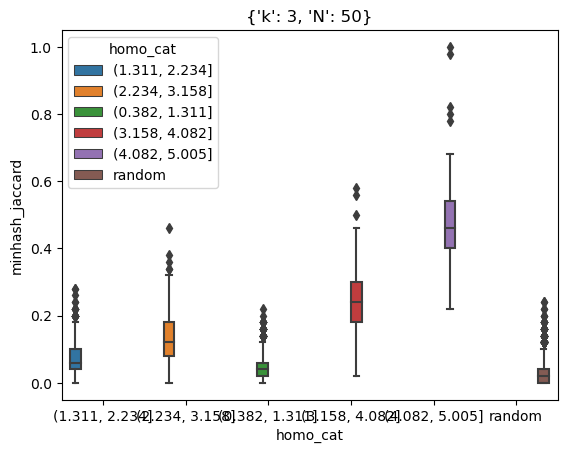

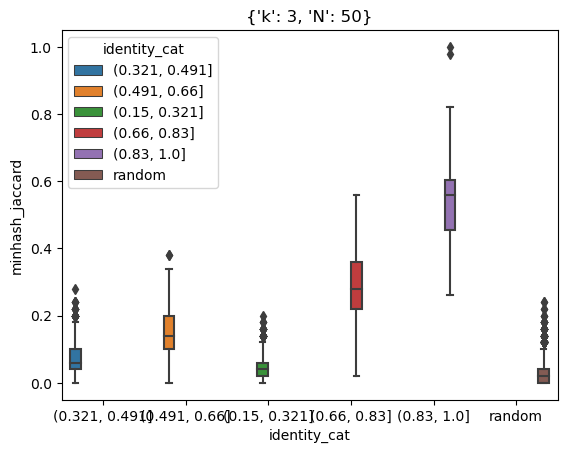

HOMO: (0.382, 1.311]. T-test Results: t-stat = 24.76040978872751, p-value = 1.5315616928948514e-131
HOMO: (1.311, 2.234]. T-test Results: t-stat = 43.725144879011665, p-value = 0.0
HOMO: (2.234, 3.158]. T-test Results: t-stat = 50.76010818247125, p-value = 3.3376602629102126e-291
HOMO: (3.158, 4.082]. T-test Results: t-stat = 49.07542447316597, p-value = 1.7351851608383108e-179
HOMO: (4.082, 5.005]. T-test Results: t-stat = 23.3236176690083, p-value = 4.2677282121373434e-32
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 20.693772856879658, p-value = 4.1624076465355776e-93
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 50.020074954083874, p-value = 0.0
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 56.957597009127035, p-value = 5.69124e-319
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 47.28036221093743, p-value = 1.677190690713956e-138
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 16.173060348268837, p-value = 2.0449613404910002e-15


(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

In [29]:
compare_jaccard_scores(real_data_df, null_df, k=3, N=50)

## repeat for different k and N

In [31]:
def analyze_k_perm(k_values, num_perm_values):
    """Analyze how different k and num_perm values affect the output."""
    for k in k_values:
        for num_perm in num_perm_values:
            null_scores = compute_jaccard_pairs(null_sequences, k, num_perm)
            null_df = pd.DataFrame({'minhash_jaccard': null_scores})
            real_scores = compute_jaccard_pairs(real_sequences, k, num_perm)
            real_data_df = real_data.copy()
            real_data_df['minhash_jaccard'] = real_scores
            compare_jaccard_scores(real_data_df, null_df, k=k, N=num_perm)
            

###################### {'k': 2, 'N': 10} ###########################


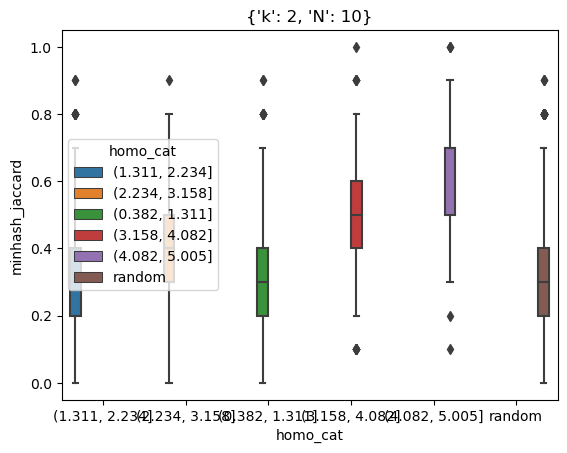

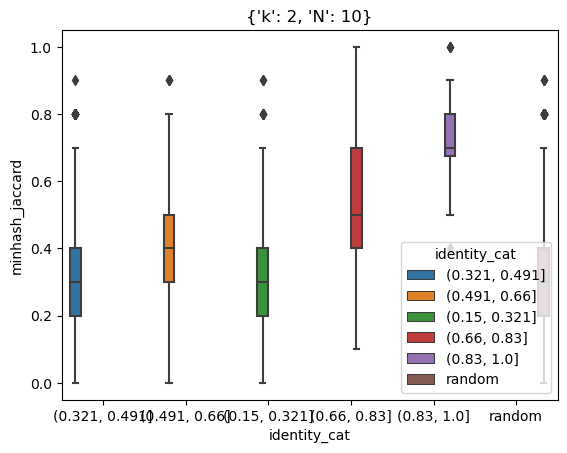

HOMO: (0.382, 1.311]. T-test Results: t-stat = 6.128144453731172, p-value = 9.152866845559874e-10
HOMO: (1.311, 2.234]. T-test Results: t-stat = 11.194085082752968, p-value = 8.927856096361997e-29
HOMO: (2.234, 3.158]. T-test Results: t-stat = 14.775596226856063, p-value = 8.243552761176849e-46
HOMO: (3.158, 4.082]. T-test Results: t-stat = 20.510753293297718, p-value = 4.091536799589047e-67
HOMO: (4.082, 5.005]. T-test Results: t-stat = 13.737568750693924, p-value = 2.0321126924182352e-20
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 4.614093384109817, p-value = 3.990931337053415e-06
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 12.474846904786961, p-value = 2.3002088585623658e-35
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 18.585390997038107, p-value = 5.469265971020021e-68
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 21.680934250528583, p-value = 9.646714741859586e-64
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 14.46582820681381, p-value = 2.747797551718446e-1

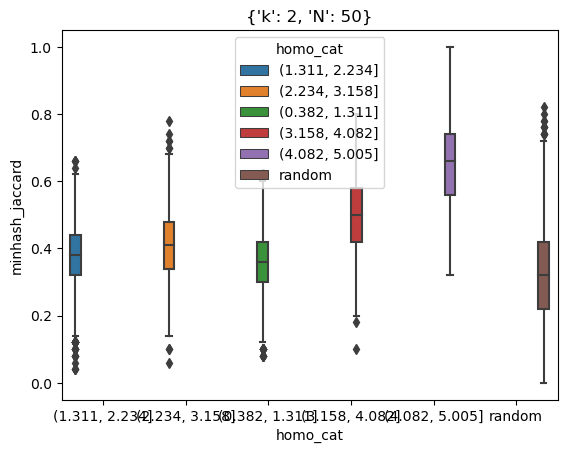

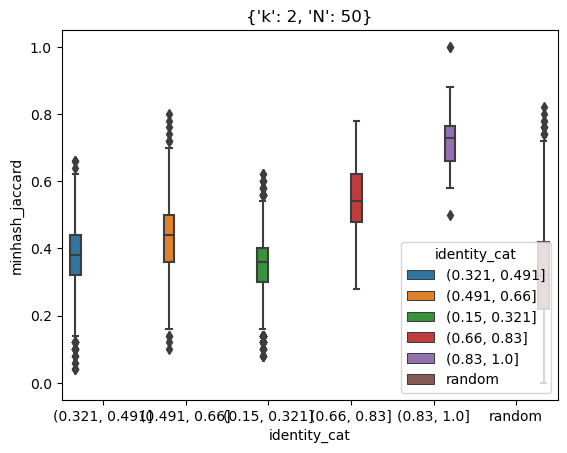

HOMO: (0.382, 1.311]. T-test Results: t-stat = 20.04955982796477, p-value = 2.875953148739965e-88
HOMO: (1.311, 2.234]. T-test Results: t-stat = 23.406165323981448, p-value = 1.4118708774381973e-116
HOMO: (2.234, 3.158]. T-test Results: t-stat = 25.627701828895244, p-value = 1.8973555008011797e-119
HOMO: (3.158, 4.082]. T-test Results: t-stat = 31.67901759419715, p-value = 5.300238097755116e-120
HOMO: (4.082, 5.005]. T-test Results: t-stat = 19.829441370423144, p-value = 1.822245400801406e-28
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 17.341162961854057, p-value = 1.1317880875876481e-66
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 26.527848867275015, p-value = 1.39145304027455e-149
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 31.154795470656524, p-value = 5.816413479703474e-160
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 34.40658055560964, p-value = 9.43407346852612e-109
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 20.03332591068316, p-value = 7.95839458440666

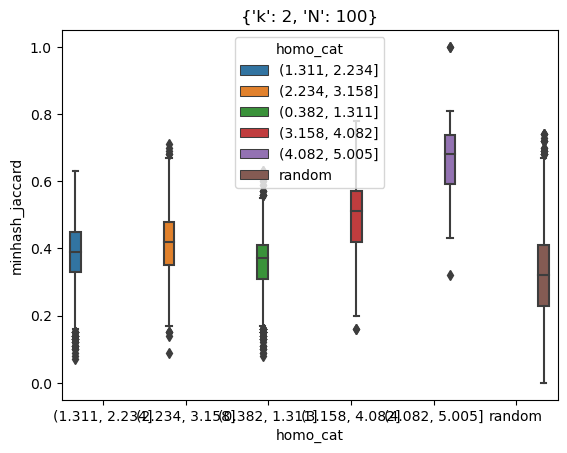

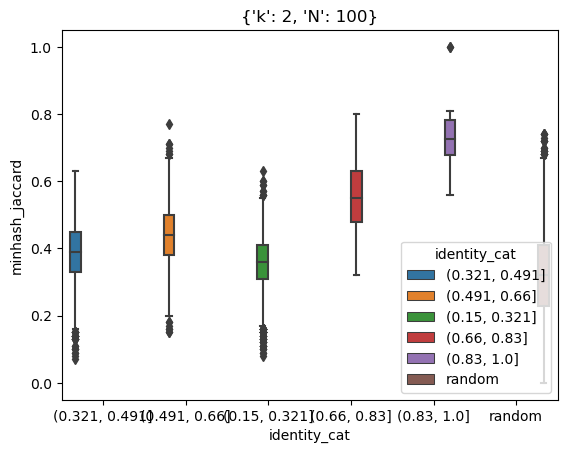

HOMO: (0.382, 1.311]. T-test Results: t-stat = 22.906857269309125, p-value = 3.271449488808364e-114
HOMO: (1.311, 2.234]. T-test Results: t-stat = 29.161085611309062, p-value = 2.0218744196589104e-176
HOMO: (2.234, 3.158]. T-test Results: t-stat = 29.066439430987582, p-value = 7.092772515454294e-147
HOMO: (3.158, 4.082]. T-test Results: t-stat = 33.26928729026886, p-value = 4.2694621619252835e-127
HOMO: (4.082, 5.005]. T-test Results: t-stat = 22.649728116219396, p-value = 1.2292959796427318e-31
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 19.883670627948053, p-value = 8.115187263245875e-87
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 32.51179114615445, p-value = 3.896125478455631e-220
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 34.80901219834416, p-value = 4.868998078306781e-190
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 37.82548332329453, p-value = 1.7487774773485995e-119
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 23.06828426488547, p-value = 2.00109190575

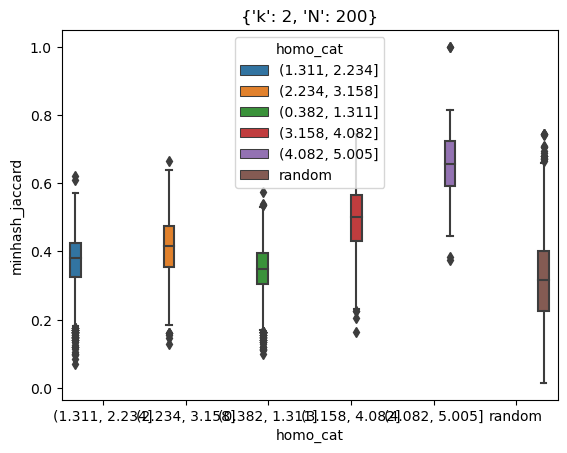

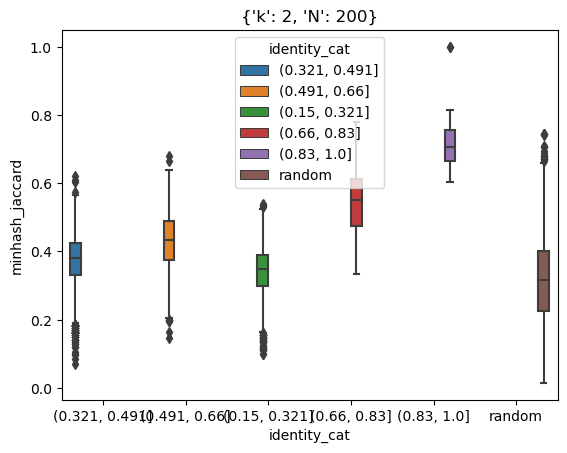

HOMO: (0.382, 1.311]. T-test Results: t-stat = 21.517985979968298, p-value = 3.212767470756364e-101
HOMO: (1.311, 2.234]. T-test Results: t-stat = 29.57436967866042, p-value = 6.056325826318463e-182
HOMO: (2.234, 3.158]. T-test Results: t-stat = 32.757797365979506, p-value = 2.83305571045916e-178
HOMO: (3.158, 4.082]. T-test Results: t-stat = 36.33232821357497, p-value = 1.2452799990400385e-140
HOMO: (4.082, 5.005]. T-test Results: t-stat = 22.799241890586845, p-value = 8.816222879681549e-32
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 18.365517893340733, p-value = 1.6602567008941769e-74
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 33.22585599844189, p-value = 3.6692785526882724e-230
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 39.11574298582337, p-value = 4.212100751943393e-227
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 41.83337915143888, p-value = 1.39827690854535e-131
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 22.729218745111385, p-value = 3.02641207753717

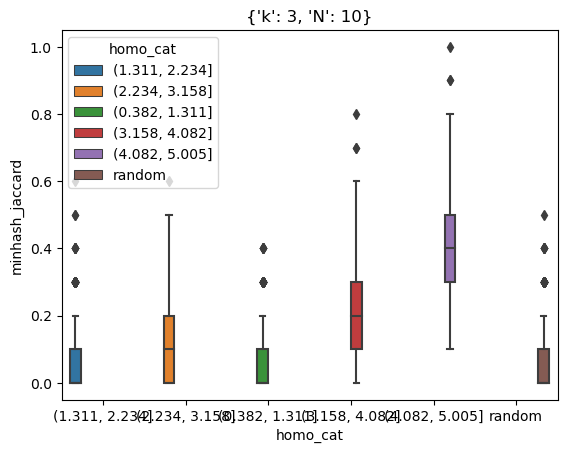

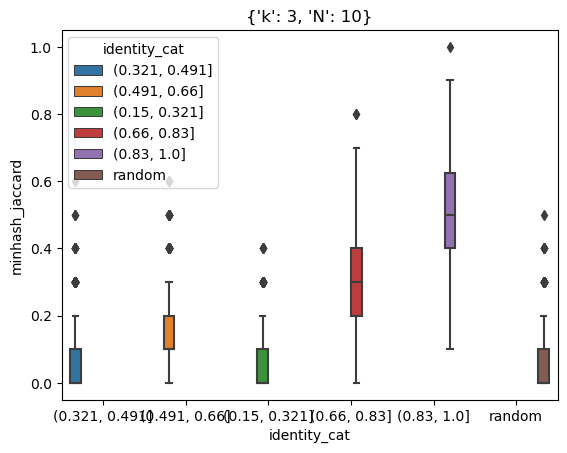

HOMO: (0.382, 1.311]. T-test Results: t-stat = 10.601476343247207, p-value = 4.0283014268121376e-26
HOMO: (1.311, 2.234]. T-test Results: t-stat = 20.152897247226996, p-value = 4.9767236553126724e-86
HOMO: (2.234, 3.158]. T-test Results: t-stat = 27.699624982388634, p-value = 5.800608346074615e-129
HOMO: (3.158, 4.082]. T-test Results: t-stat = 29.55573097542766, p-value = 2.892734865448592e-106
HOMO: (4.082, 5.005]. T-test Results: t-stat = 16.34930495062826, p-value = 5.550894341566061e-24
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 8.2775463829947, p-value = 1.4333100956108464e-16
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 23.7113481963614, p-value = 5.256696324484423e-118
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 30.2135214864725, p-value = 7.776566130327436e-144
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 27.770958067150644, p-value = 7.467619737797554e-84
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 12.106035078107285, p-value = 2.016439693252668e-12

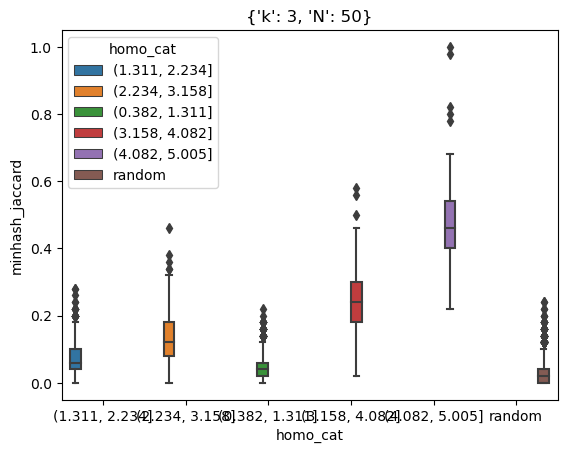

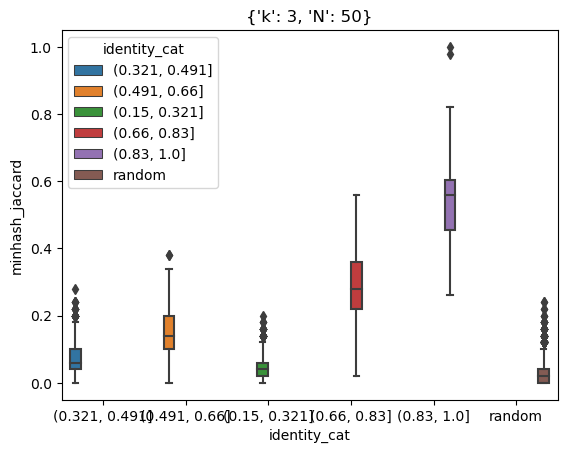

HOMO: (0.382, 1.311]. T-test Results: t-stat = 24.76040978872751, p-value = 1.5315616928948514e-131
HOMO: (1.311, 2.234]. T-test Results: t-stat = 43.725144879011665, p-value = 0.0
HOMO: (2.234, 3.158]. T-test Results: t-stat = 50.76010818247125, p-value = 3.3376602629102126e-291
HOMO: (3.158, 4.082]. T-test Results: t-stat = 49.07542447316597, p-value = 1.7351851608383108e-179
HOMO: (4.082, 5.005]. T-test Results: t-stat = 23.3236176690083, p-value = 4.2677282121373434e-32
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 20.693772856879658, p-value = 4.1624076465355776e-93
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 50.020074954083874, p-value = 0.0
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 56.957597009127035, p-value = 5.69124e-319
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 47.28036221093743, p-value = 1.677190690713956e-138
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 16.173060348268837, p-value = 2.0449613404910002e-15
###################### {'k': 3, 'N': 1

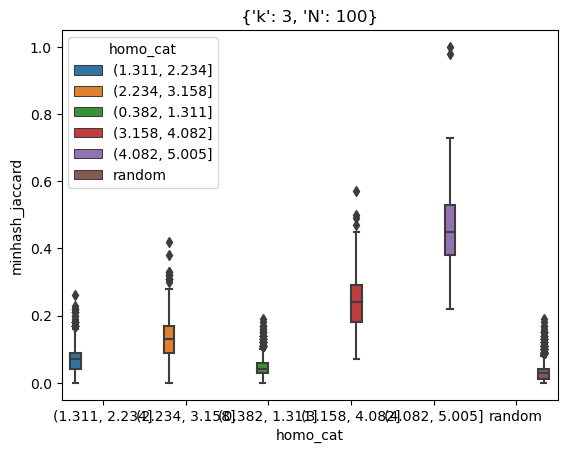

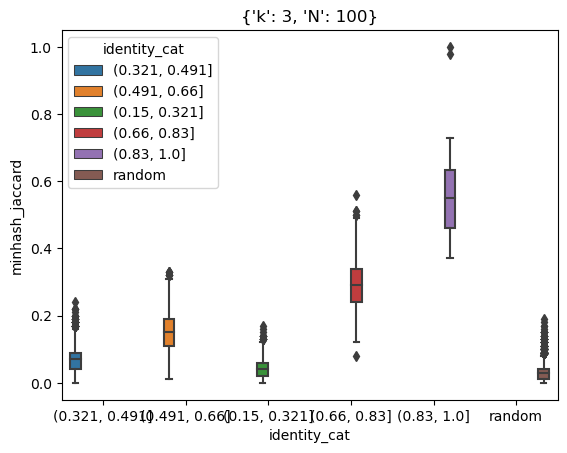

HOMO: (0.382, 1.311]. T-test Results: t-stat = 33.601447251357605, p-value = 3.406730358405307e-235
HOMO: (1.311, 2.234]. T-test Results: t-stat = 56.7475731515634, p-value = 0.0
HOMO: (2.234, 3.158]. T-test Results: t-stat = 58.25518899149312, p-value = 0.0
HOMO: (3.158, 4.082]. T-test Results: t-stat = 54.89174787542189, p-value = 1.569294553982502e-197
HOMO: (4.082, 5.005]. T-test Results: t-stat = 23.26420050419792, p-value = 4.939292523138968e-32
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 28.738593408827917, p-value = 1.6926849314912711e-174
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 64.39547198399175, p-value = 0.0
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 68.91346369674515, p-value = 0.0
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 55.17478155417716, p-value = 5.365621174616412e-156
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 19.384992254424237, p-value = 2.2370046995084987e-17
###################### {'k': 3, 'N': 200} ###########################


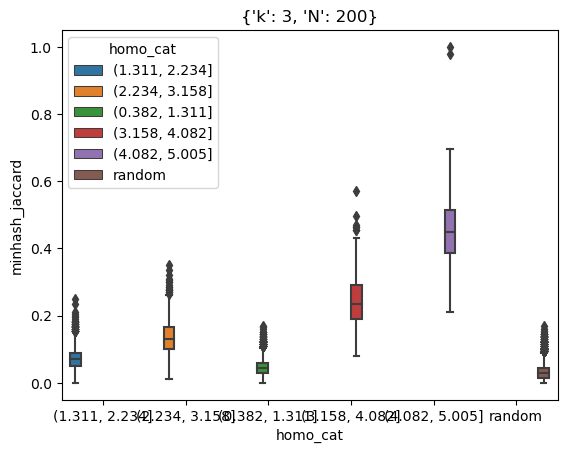

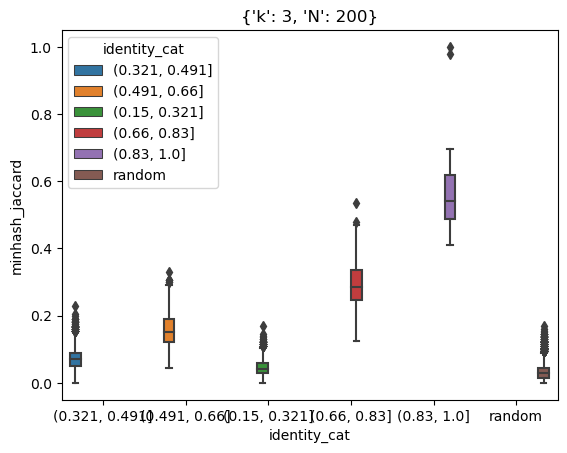

HOMO: (0.382, 1.311]. T-test Results: t-stat = 36.77404525724902, p-value = 1.3803533661162854e-279
HOMO: (1.311, 2.234]. T-test Results: t-stat = 62.36389534126234, p-value = 0.0
HOMO: (2.234, 3.158]. T-test Results: t-stat = 63.57328813638875, p-value = 0.0
HOMO: (3.158, 4.082]. T-test Results: t-stat = 57.49560996757831, p-value = 2.818505880758818e-205
HOMO: (4.082, 5.005]. T-test Results: t-stat = 22.99968469356787, p-value = 9.255713881797948e-32
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 30.98587839343515, p-value = 6.665235666431778e-202
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 72.51649234964958, p-value = 0.0
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 75.45664308957718, p-value = 0.0
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 58.99349873007474, p-value = 8.223179979476945e-164
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 19.940952470116404, p-value = 1.0937820958043482e-17
###################### {'k': 4, 'N': 10} ###########################


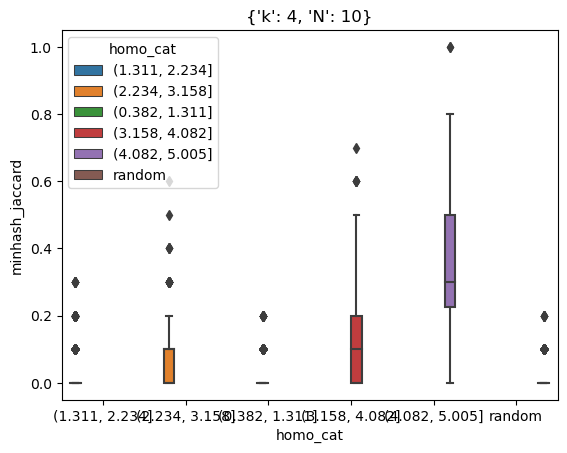

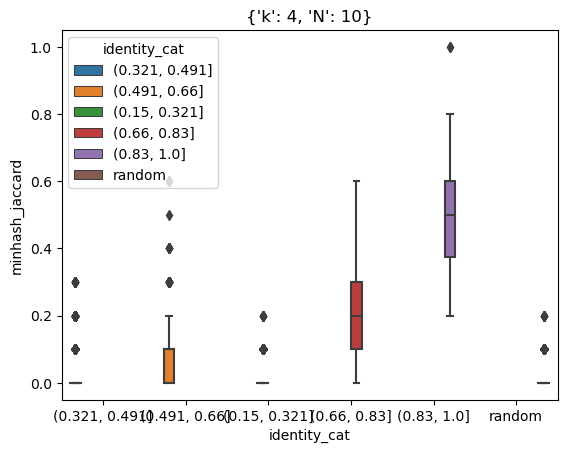

HOMO: (0.382, 1.311]. T-test Results: t-stat = 11.955236619538129, p-value = 1.1958425943239602e-32
HOMO: (1.311, 2.234]. T-test Results: t-stat = 23.45308010703433, p-value = 2.900822778486041e-112
HOMO: (2.234, 3.158]. T-test Results: t-stat = 26.86359344901258, p-value = 8.834159993667007e-122
HOMO: (3.158, 4.082]. T-test Results: t-stat = 22.86013568865788, p-value = 2.3235958267638833e-76
HOMO: (4.082, 5.005]. T-test Results: t-stat = 14.53609043290324, p-value = 1.752249058849935e-21
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 10.333090352288702, p-value = 7.506208664985881e-25
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 26.125157460502763, p-value = 6.213777678748171e-139
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 27.629791762227516, p-value = 7.46194081736377e-125
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 22.79980864722475, p-value = 1.458007961116628e-66
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 12.177326085170849, p-value = 1.7720306910221614e

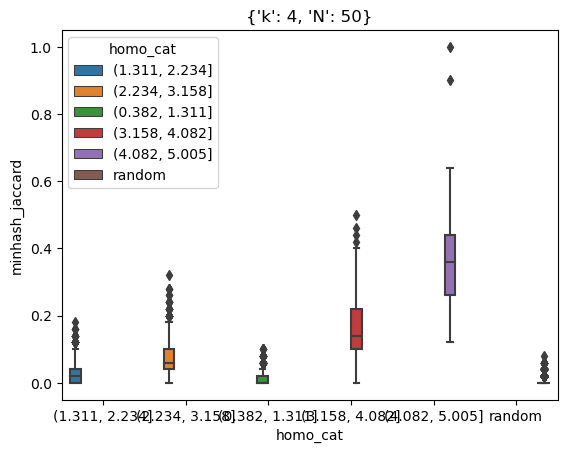

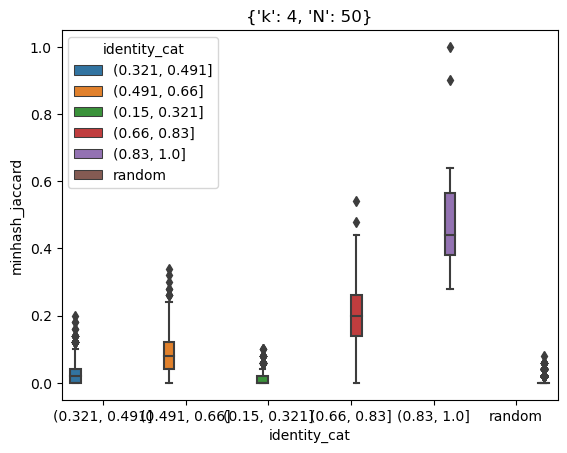

HOMO: (0.382, 1.311]. T-test Results: t-stat = 26.930294364638673, p-value = 2.5456788876641365e-152
HOMO: (1.311, 2.234]. T-test Results: t-stat = 44.73382911608326, p-value = 0.0
HOMO: (2.234, 3.158]. T-test Results: t-stat = 44.29590277639061, p-value = 1.4233768951927397e-243
HOMO: (3.158, 4.082]. T-test Results: t-stat = 37.93351392537787, p-value = 1.770653541811191e-139
HOMO: (4.082, 5.005]. T-test Results: t-stat = 18.173300352220007, p-value = 2.659014354471283e-26
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 23.29537534579798, p-value = 1.6753283673887152e-115
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 49.834375632485106, p-value = 0.0
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 47.80790208332101, p-value = 1.0992351727453865e-258
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 37.74342191470827, p-value = 9.731928263362284e-114
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 15.697624372832179, p-value = 4.259749469286045e-15
###################### {'k': 

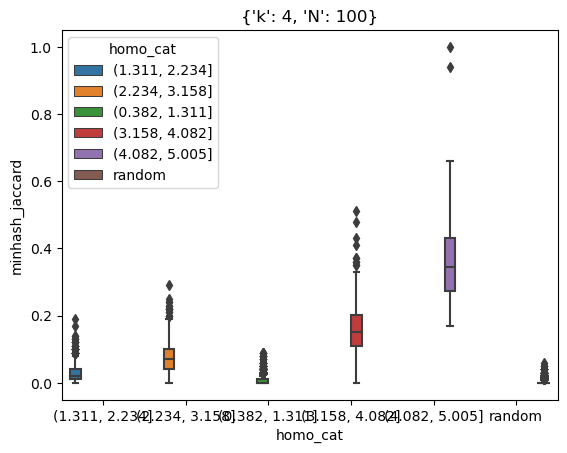

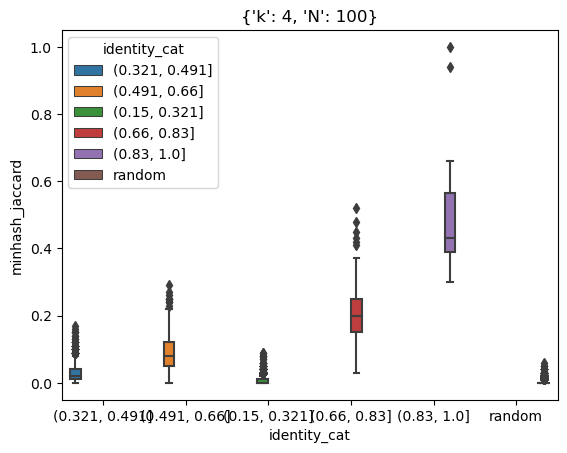

HOMO: (0.382, 1.311]. T-test Results: t-stat = 34.871146955871346, p-value = 9.973969721430654e-246
HOMO: (1.311, 2.234]. T-test Results: t-stat = 52.72039921783691, p-value = 0.0
HOMO: (2.234, 3.158]. T-test Results: t-stat = 51.55077469872904, p-value = 3.370492422420429e-291
HOMO: (3.158, 4.082]. T-test Results: t-stat = 44.33250621331768, p-value = 1.0465014552436756e-162
HOMO: (4.082, 5.005]. T-test Results: t-stat = 18.158825673061827, p-value = 2.771706156669503e-26
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 30.88598216576979, p-value = 1.1334863189283634e-195
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 58.731854894144476, p-value = 0.0
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 56.07069142252159, p-value = 2.3905117386942316e-308
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 43.40859349768765, p-value = 1.1612736260458657e-128
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 15.58069592026042, p-value = 5.113102141701463e-15
###################### {'k': 4

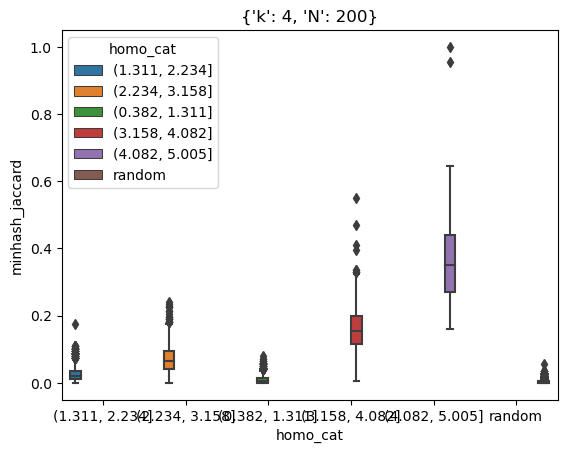

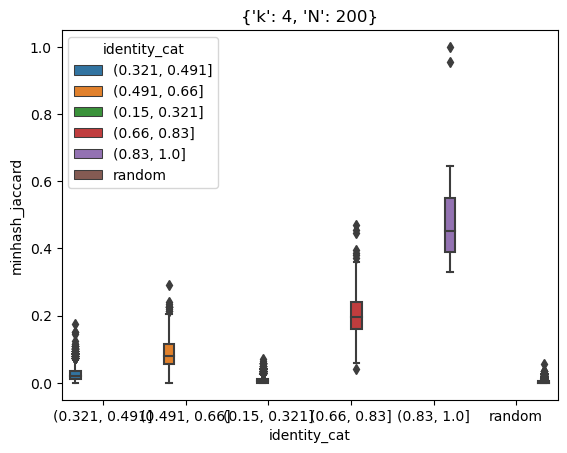

HOMO: (0.382, 1.311]. T-test Results: t-stat = 44.85396260458765, p-value = 0.0
HOMO: (1.311, 2.234]. T-test Results: t-stat = 61.34222002295647, p-value = 0.0
HOMO: (2.234, 3.158]. T-test Results: t-stat = 55.59972569480042, p-value = 1.7739109e-316
HOMO: (3.158, 4.082]. T-test Results: t-stat = 47.781205280343165, p-value = 2.3595564668099795e-174
HOMO: (4.082, 5.005]. T-test Results: t-stat = 18.377436176781142, p-value = 1.4928691572273066e-26
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 40.24918827615752, p-value = 0.0
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 67.92532959129747, p-value = 0.0
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 61.2570218045086, p-value = 0.0
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 48.5781143641412, p-value = 4.409003245556549e-141
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 16.143212926871186, p-value = 2.1466447422438936e-15
###################### {'k': 5, 'N': 10} ###########################


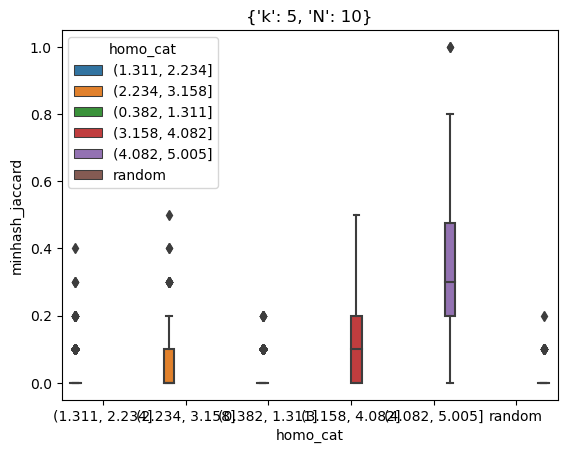

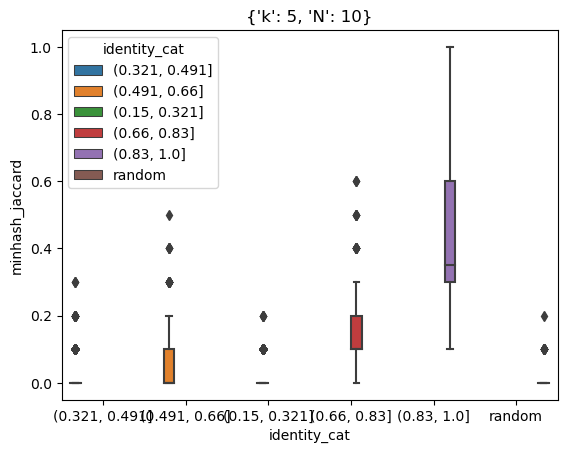

HOMO: (0.382, 1.311]. T-test Results: t-stat = 14.276137611930391, p-value = 1.7948197274442618e-45
HOMO: (1.311, 2.234]. T-test Results: t-stat = 16.975470125600797, p-value = 8.387580741172933e-62
HOMO: (2.234, 3.158]. T-test Results: t-stat = 21.049329834568894, p-value = 1.9433619241319246e-82
HOMO: (3.158, 4.082]. T-test Results: t-stat = 22.48285284394027, p-value = 1.2175771966923988e-74
HOMO: (4.082, 5.005]. T-test Results: t-stat = 11.631365118319476, p-value = 4.022263504286726e-17
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 13.298107492325771, p-value = 1.0160442669088604e-39
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 19.377801893468842, p-value = 8.334350477143387e-80
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 23.26955026487042, p-value = 1.0610494655655298e-95
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 20.506810231675015, p-value = 2.608751143402465e-58
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 9.706335270291355, p-value = 2.680694311866215

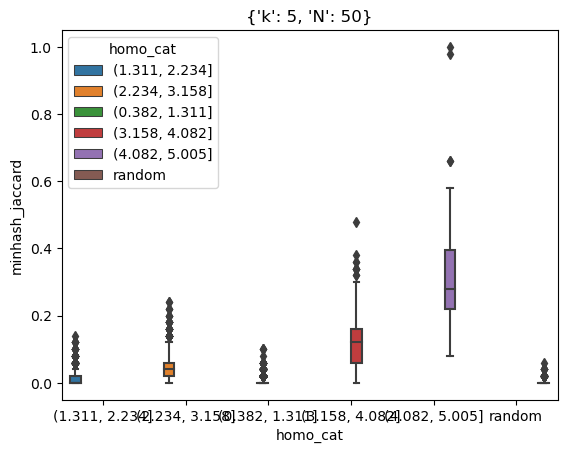

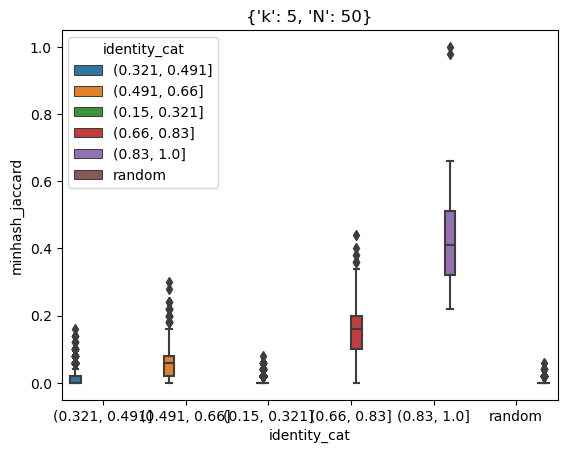

HOMO: (0.382, 1.311]. T-test Results: t-stat = 23.348100394406803, p-value = 2.4363293687855617e-115
HOMO: (1.311, 2.234]. T-test Results: t-stat = 32.81963872409088, p-value = 3.42188717491897e-202
HOMO: (2.234, 3.158]. T-test Results: t-stat = 36.06478766861339, p-value = 2.237057729432354e-186
HOMO: (3.158, 4.082]. T-test Results: t-stat = 33.91199887733787, p-value = 1.0173837346161442e-123
HOMO: (4.082, 5.005]. T-test Results: t-stat = 14.595141186491743, p-value = 1.4470845884979381e-21
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 20.786525667341856, p-value = 2.1738553534451504e-92
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 36.993232610829445, p-value = 1.7433273661478124e-255
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 39.57564229897043, p-value = 2.3041162616771203e-205
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 34.52464965082603, p-value = 1.4855925656100176e-104
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 12.11400039627312, p-value = 1.9982507704

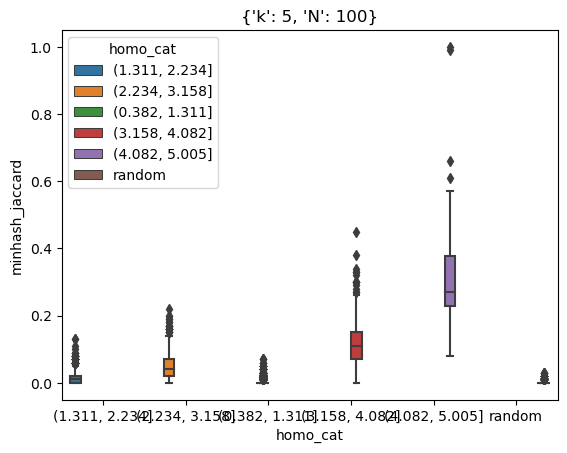

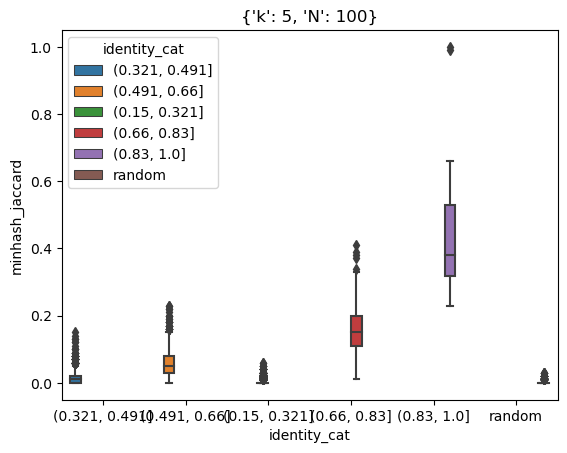

HOMO: (0.382, 1.311]. T-test Results: t-stat = 30.755954619851508, p-value = 1.9301877278019077e-192
HOMO: (1.311, 2.234]. T-test Results: t-stat = 42.26977706677537, p-value = 1.0590017578889671e-306
HOMO: (2.234, 3.158]. T-test Results: t-stat = 41.07532525343974, p-value = 3.069984664509498e-221
HOMO: (3.158, 4.082]. T-test Results: t-stat = 37.425677166921766, p-value = 1.6783275320162423e-137
HOMO: (4.082, 5.005]. T-test Results: t-stat = 14.54989574490478, p-value = 1.6776122771836591e-21
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 27.82439906278775, p-value = 3.5628270988601694e-159
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 46.5933828923467, p-value = 0.0
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 45.831940513328185, p-value = 6.777962520553362e-246
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 37.90479521976272, p-value = 3.667424326240289e-114
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 12.122658929495438, p-value = 1.965762112729862e-12
##########

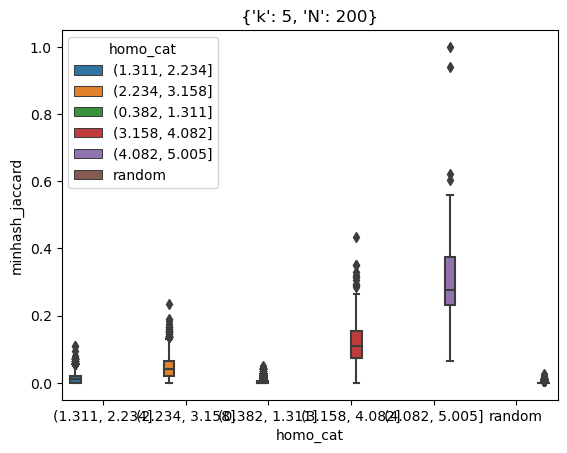

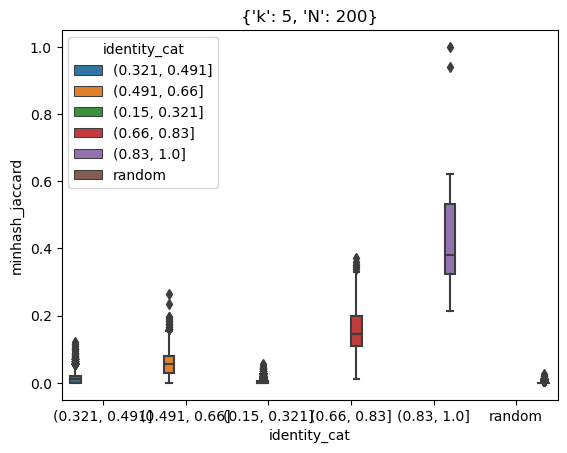

HOMO: (0.382, 1.311]. T-test Results: t-stat = 36.17794874422413, p-value = 4.294813966735573e-258
HOMO: (1.311, 2.234]. T-test Results: t-stat = 47.86129763242494, p-value = 0.0
HOMO: (2.234, 3.158]. T-test Results: t-stat = 45.164276641675144, p-value = 5.409827222454039e-249
HOMO: (3.158, 4.082]. T-test Results: t-stat = 39.06179040561016, p-value = 1.0886066235372338e-143
HOMO: (4.082, 5.005]. T-test Results: t-stat = 15.426402989415703, p-value = 1.0023877995834576e-22
IDENTITY: (0.15, 0.321]. T-test Results: t-stat = 32.332406701425555, p-value = 3.177760770698569e-209
IDENTITY: (0.321, 0.491]. T-test Results: t-stat = 52.71013224113605, p-value = 0.0
IDENTITY: (0.491, 0.66]. T-test Results: t-stat = 49.663030703088666, p-value = 9.257942501312984e-270
IDENTITY: (0.66, 0.83]. T-test Results: t-stat = 39.68724775829573, p-value = 5.297758106622889e-119
IDENTITY: (0.83, 1.0]. T-test Results: t-stat = 12.954492834197808, p-value = 4.2232211922162177e-13


In [32]:
analyze_k_perm([2,3,4,5], [10, 50, 100, 200])

## Evaluate T for chosen parameters 

In [13]:
real_scores = compute_jaccard_pairs(real_sequences, 4, 128)
real_data_df = real_data.copy()
real_data_df['minhash_jaccard'] = real_scores

In [16]:
real_data_df['homo_cat'] = pd.cut(real_data_df['homo'], 5)
real_data_df['identity_cat'] = pd.cut(real_data_df['identity'], 5)

In [21]:
for _, g in real_data_df.groupby('homo_cat'):
    t_stat, p_value = stats.ttest_1samp(g['minhash_jaccard'], 0.2, alternative='greater')
    print(f'HOMO: {_}. T-test Results: t-stat = {t_stat}, p-value = {p_value}')

HOMO: (0.366, 1.309]. T-test Results: t-stat = -1294.9779985318578, p-value = 1.0
HOMO: (1.309, 2.246]. T-test Results: t-stat = -461.0105930387483, p-value = 1.0
HOMO: (2.246, 3.184]. T-test Results: t-stat = -92.61811374169046, p-value = 1.0
HOMO: (3.184, 4.122]. T-test Results: t-stat = -6.9893523002683065, p-value = 0.9999999999939225
HOMO: (4.122, 5.059]. T-test Results: t-stat = 11.93581320385908, p-value = 4.919036930252985e-19
